In [19]:
from hands import process
import os
import imageio.v3 as imageio
from matplotlib import pyplot as plt
import numpy as np
import string
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.src.models import Sequential
from keras.src.layers import Dense, Dropout

In [2]:
asl_dict = {char: [] for char in string.digits + string.ascii_lowercase}
asl_dir = "asl_dataset"

sub_dirs = sorted([d for d in os.listdir(asl_dir) if os.path.isdir(os.path.join(asl_dir, d))])

for dir in sub_dirs:
    cur = os.path.join(asl_dir,dir)
    for img in os.listdir(cur):
        image_path = os.path.join(cur, img)
        im = imageio.imread(image_path)
        frame, landmarks = process(im, False, 1)
        try:
            asl_dict[dir].append(landmarks)
        except Exception as e:
            print(f'{e}: error adding to dict')

I0000 00:00:1730762728.912614 8729711 gl_context.cc:357] GL version: 2.1 (2.1 ATI-5.5.17), renderer: AMD Radeon Pro 5300M OpenGL Engine
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1730762729.005027 8730047 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1730762729.037016 8730038 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1730762729.051951 8730042 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.
/Users/jagan-kalsi/Desktop/class/csc/csc487/asl/myenv/lib/python3.10/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. Sym

In [13]:
X = []
y = []

# Collect landmarks and corresponding labels
for label, landmarks_list in asl_dict.items():
    for landmarks in landmarks_list:
        if landmarks is not None and len(landmarks) == 63:  # Ensure landmarks are valid
            X.append(landmarks)
            y.append(label)

# Convert to NumPy arrays
X = np.array(X, dtype=np.float32)  # Shape: (n_samples, 63)
y = np.array(y)  # Keep y as an array of strings for encoding

# Encode the labels to integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Now y_encoded is numeric

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)


In [29]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(63,)),  # First hidden layer
    Dropout(0.2),  # Dropout layer to reduce overfitting
    Dense(64, activation='relu'),  # Second hidden layer
    Dropout(0.2),  # Another Dropout layer
    Dense(32, activation='relu'),  # Third hidden layer
    Dropout(0.2),  # Dropout layer before output
    Dense(len(label_encoder.classes_), activation='softmax')  # Output layer
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [30]:
history = model.fit(X_train, y_train, epochs=150, batch_size=8, validation_data=(X_test, y_test))


Epoch 1/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0448 - loss: 3.5361 - val_accuracy: 0.1442 - val_loss: 3.2951
Epoch 2/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0926 - loss: 3.2586 - val_accuracy: 0.3006 - val_loss: 2.7158
Epoch 3/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1768 - loss: 2.7329 - val_accuracy: 0.4325 - val_loss: 2.0830
Epoch 4/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3067 - loss: 2.1398 - val_accuracy: 0.5951 - val_loss: 1.5496
Epoch 5/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3888 - loss: 1.7661 - val_accuracy: 0.6933 - val_loss: 1.2406
Epoch 6/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4406 - loss: 1.5478 - val_accuracy: 0.7209 - val_loss: 1.0437
Epoch 7/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5224 - loss: 1.3232 - val_accuracy: 0.7975 - val_loss: 0.9159
Epoch 8/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6035 - loss: 1.1832 - val_accu

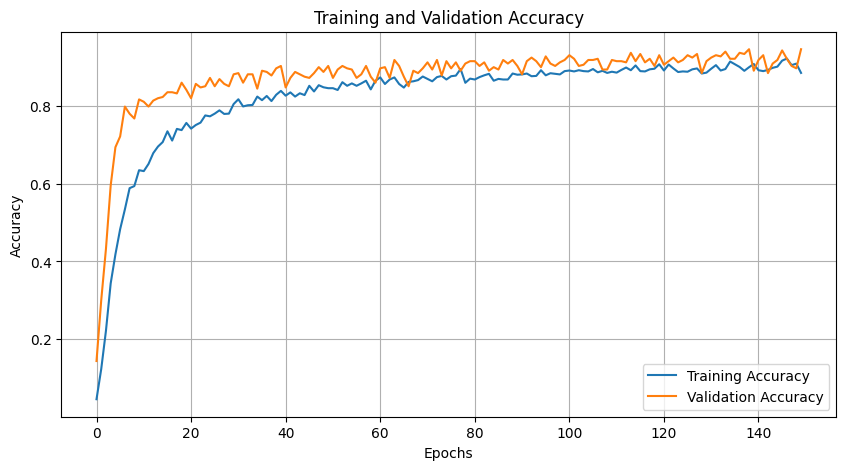

In [31]:
plt.figure(figsize=(10, 5))

plt.plot(history.history['accuracy'], label='Training Accuracy')

plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [33]:
model.save('asl-model.keras')